# Aufgabenstellung

Lade die Survey Results der Stack Overflow Annual Developer Survey von 2020 (https://insights.stackoverflow.com/survey) herunter. Benutze eine Umgebung deiner Wahl (z.B. Jupyter, RStudio, Google Colab) für folgende Aufgabe:

Entwickele ein Machine Learning Modell, das die Zielvariable ConvertedComp (Jahresgehalt in USD) vorhersagt. Um es einfach zu halten, beschränke dich auf den Inhalt des Felds LanguageWorkedWith (Programmiersprachen, mit denen die Person gearbeitet hat, Semikolon-separiert) für die Prädiktoren.

 

Im Termin kannst du uns dann per Screenshare zeigen, wie du bei der Lösung des Problems vorgegangen bist.

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib  inline

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split, RandomizedSearchCV, RepeatedKFold, RepeatedStratifiedKFold
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline

from scipy.stats import randint, uniform

# Sklearn Regressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.svm import SVR

from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier

from sklearn.metrics import roc_curve, auc

# My modules
from MachineLearning import SpotChecking
from utils.utils import loguniform

# Parameters

In [2]:
# Plotting
sns.set(font_scale=1.5)
mpl.rcParams['figure.figsize'] = (12, 7)

# Load data

In [3]:
developer_survey = pd.read_csv('data/developer_survey_2020/survey_results_public.csv')
developer_survey = developer_survey[['ConvertedComp', 'LanguageWorkedWith']]

# Preprocess

In [4]:
# Remove all NA rows
mask = developer_survey.isna().all(axis=1)
developer_survey = developer_survey[~mask]

# Data Analysis

In [5]:
developer_survey.head()

ConvertedComp        LanguageWorkedWith
0            NaN    C#;HTML/CSS;JavaScript
1            NaN          JavaScript;Swift
2            NaN  Objective-C;Python;Swift
4            NaN         HTML/CSS;Ruby;SQL
5            NaN  HTML/CSS;Java;JavaScript

In [6]:
developer_survey.dtypes

ConvertedComp         float64
LanguageWorkedWith     object
dtype: object

### Target: ConvertedComp (annual income)

In [7]:
developer_survey.ConvertedComp.describe()

count    3.475600e+04
mean     1.037561e+05
std      2.268853e+05
min      0.000000e+00
25%      2.464800e+04
50%      5.404900e+04
75%      9.500000e+04
max      2.000000e+06
Name: ConvertedComp, dtype: float64

In [8]:
(developer_survey.ConvertedComp == 0).mean()

0.0024196159285702116

Text(0, 0.5, 'Frequency')

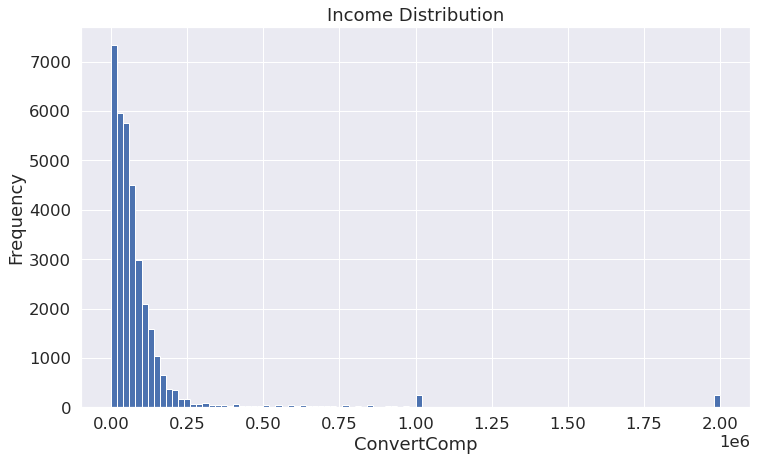

In [9]:
developer_survey.ConvertedComp.hist(bins=100)
# plt.yscale('log')
# plt.xscale('log')
plt.title('Income Distribution')
plt.xlabel('ConvertComp')
plt.ylabel('Frequency')

In [10]:
(developer_survey.ConvertedComp==2e6).sum()

258

In [11]:
(developer_survey.ConvertedComp==1e6).sum()

258

In [12]:
developer_survey.shape[1] / (2*258)

0.003875968992248062

**Observation:**

- Entries for incomes of 1e6 and 2e6 look like outliers
- These entries describe less than 0.5% of the population 

**Decision:**

- Discard these entries

Text(0.5, 1.0, 'Income Distribution')

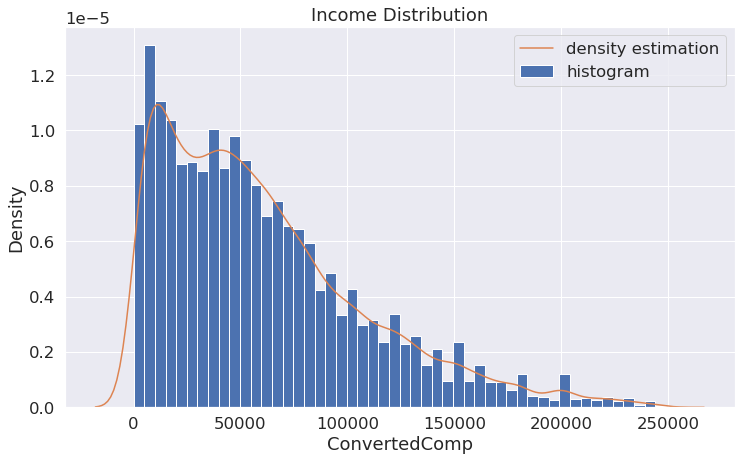

In [13]:
mask = developer_survey.ConvertedComp < 2.5e5
# mask = developer_survey.ConvertedComp < 1e6
_, bins, _ = plt.hist(developer_survey[mask].ConvertedComp, 
                      bins=50, 
                      density=True,
                     label='histogram')
sns.kdeplot(developer_survey[mask].ConvertedComp,
           label='density estimation')
plt.legend()
plt.title('Income Distribution')

In [14]:
mask_ub = developer_survey.ConvertedComp < 2.5e5
mask_valid_income = ~developer_survey.ConvertedComp.isna()
perc = mask_ub.sum() / mask_valid_income.sum()
print(f'{perc*100:.2f}% of (valid) incomes are below 2.5e5')

94.49% of (valid) incomes are below 2.5e5


**Observation:**

- Could be a bimodal distribution
- Could it be part-time/hobby/freelance vs full-time developers?

In [15]:
print(f'Target variable exhibits {developer_survey.ConvertedComp.isna().mean()*100:.2f}% missing values.')

Target variable exhibits 40.78% missing values.


### Predictor: LanguageWorkedWith

In [16]:
developer_survey.LanguageWorkedWith

0                                   C#;HTML/CSS;JavaScript
1                                         JavaScript;Swift
2                                 Objective-C;Python;Swift
4                                        HTML/CSS;Ruby;SQL
5                                 HTML/CSS;Java;JavaScript
                               ...                        
64447                    C#;HTML/CSS;Java;JavaScript;Swift
64453                                         C++;HTML/CSS
64457    Assembly;Bash/Shell/PowerShell;C;C#;C++;Dart;G...
64459                                             HTML/CSS
64460                      C#;HTML/CSS;Java;JavaScript;SQL
Name: LanguageWorkedWith, Length: 58687, dtype: object

In [17]:
developer_survey.shape

(58687, 2)

**Observation:** 

- All languages in string separated by semicolons

**Decision:**

- Create binary variables for each programming language

**Note:**

- Number of programming languages can be expected to be indicative of annual income

In [18]:
developer_survey.LanguageWorkedWith.isna().sum()

1309

Text(0, 0.5, 'Frequency')

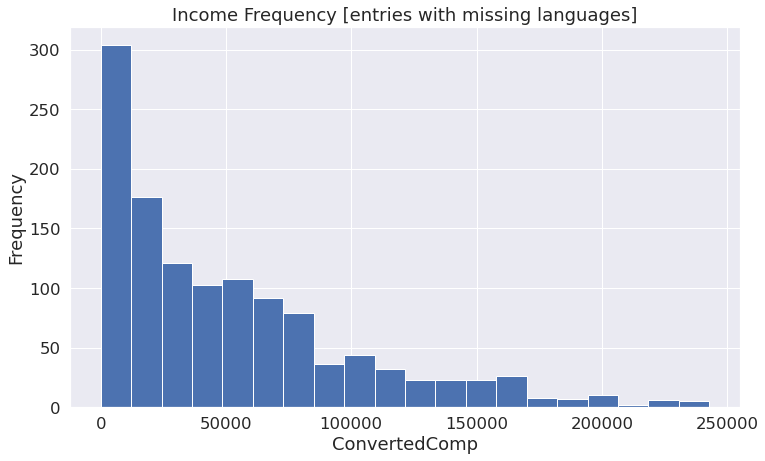

In [19]:
mask = (developer_survey.LanguageWorkedWith.isna() &
       (developer_survey.ConvertedComp < 2.5e5))
developer_survey.loc[mask, 'ConvertedComp'].hist(bins=20)
plt.title('Income Frequency [entries with missing languages]')
plt.xlabel('ConvertedComp')
plt.ylabel('Frequency')

**Observation:** 

- Small number of samples with missing language entries
- Same pattern like for complete dataset
- Missing language entries are not indicative of income

**Decision:**

- Remove missing language entries

# Data Preparation & Further Analysis

In [20]:
# Remove rows with missing target
mask = ~developer_survey.ConvertedComp.isna()
developer_survey = developer_survey[mask]

# Remove rows without language info
mask = ~developer_survey.LanguageWorkedWith.isna()
developer_survey = developer_survey[mask]

# Extract all unique languages
mask = ~developer_survey.LanguageWorkedWith.isna()
language_combs_unique = developer_survey.LanguageWorkedWith[mask].unique().tolist()
languages = []
for comb in language_combs_unique:
    languages.extend(comb.split(';'))
languages = list(set(languages))
languages

['C++',
 'Scala',
 'Go',
 'Java',
 'Rust',
 'TypeScript',
 'HTML/CSS',
 'Bash/Shell/PowerShell',
 'Perl',
 'Objective-C',
 'Swift',
 'R',
 'PHP',
 'Haskell',
 'Julia',
 'Kotlin',
 'SQL',
 'VBA',
 'Dart',
 'Ruby',
 'C#',
 'Assembly',
 'C',
 'JavaScript',
 'Python']

In [21]:
# Create design matrix
design_df = pd.DataFrame(0, index=developer_survey.index, columns = languages)
with_language_entry = ~developer_survey.LanguageWorkedWith.isna()
for idx in developer_survey.index[with_language_entry]:
    languages_individual = developer_survey.loc[idx, 'LanguageWorkedWith'].split(';')
    design_df.loc[idx, languages_individual] = 1
design_df['Income'] = developer_survey.ConvertedComp
design_df['Number_languages'] = design_df[languages].sum(axis=1)
design_df

C++  Scala  Go  Java  Rust  TypeScript  HTML/CSS  \
7        0      0   0     0     0           0         0   
9        0      0   0     1     0           0         1   
10       0      0   0     0     0           0         0   
11       0      0   0     0     0           0         1   
12       0      0   0     0     0           0         0   
...    ...    ...  ..   ...   ...         ...       ...   
64100    0      0   1     0     1           0         0   
64111    0      0   0     0     0           0         1   
64121    0      0   0     0     0           0         1   
64122    0      0   0     0     0           1         0   
64142    0      0   0     0     0           1         1   

       Bash/Shell/PowerShell  Perl  Objective-C  ...  VBA  Dart  Ruby  C#  \
7                          0     0            0  ...    0     0     0   0   
9                          0     0            0  ...    0     0     0   0   
10                         0     0            0  ...    0     0     0   1   
11                         0     0            0  ...    0     0     0   0   
12                         0     0            0  ...    0     0     0   0   
...                      ...   ...          ...  ...  ...   ...   ...  ..   
64100                      1     0            0  ...    0     0     0   0   
64111                      0     0            0  ...    0     0     0   1   
64121                      1     0            0  ...    1     0     0   0   
64122                      0     0            0  ...    0     0     0   0   
64142                      0     0            0  ...    0     0     0   0   

       Assembly  C  JavaScript  Python    Income  Number_languages  
7             0  0           0       1  116000.0                 2  
9             0  0           1       1   32315.0                 5  
10            0  0           1       0   40070.0                 3  
11            0  0           1       0   14268.0                 2  
12            0  1           1       1   38916.0                 3  
...         ... ..         ...     ...       ...               ...  
64100         0  1           0       1   80172.0                 5  
64111         0  0           1       0    2508.0                 4  
64121         0  0           1       0     369.0                 6  
64122         0  0           1       1   70000.0                 3  
64142         0  0           1       0     984.0                 4  

[33447 rows x 27 columns]

In [22]:
# Remove rows with income of 1e6 & 2e6 (potentially outliers)
mask = ((design_df.Income == 1e6) |
        (design_df.Income == 2e6)) 
design_df = design_df[~mask]

Text(0, 0.5, 'Language')

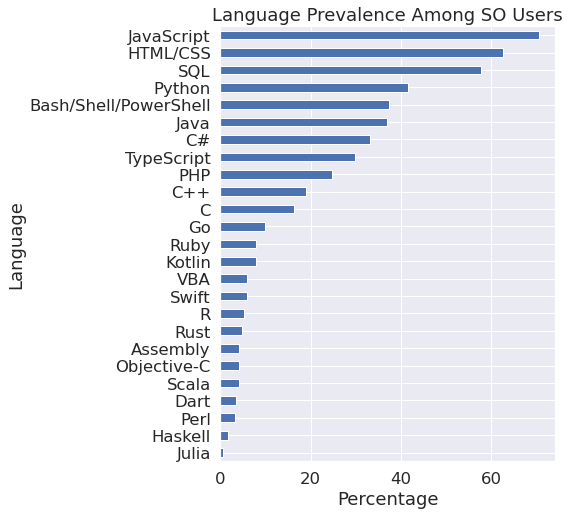

In [23]:
(design_df[languages].mean(axis=0) * 100).sort_values(ascending=True).plot(kind='barh', figsize=(6, 8))
plt.title('Language Prevalence Among SO Users')
plt.xlabel('Percentage')
plt.ylabel('Language')

In [24]:
tail_number = 4000
design_df_upper = design_df.sort_values('Income', ascending=False).head(tail_number)
design_df_lower = design_df.sort_values('Income', ascending=False).tail(tail_number)

Text(0, 0.5, 'Language')

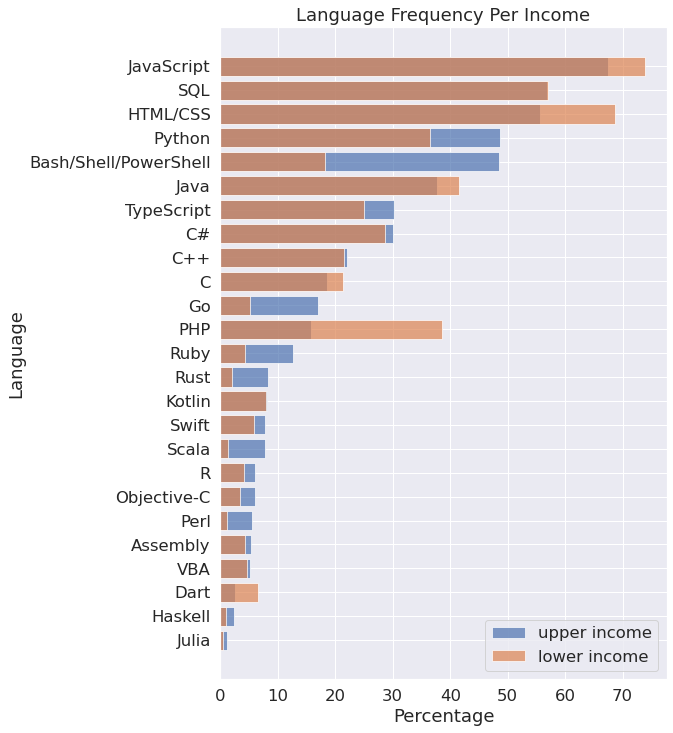

In [25]:
s_upper = design_df_upper.mean(axis=0).apply(lambda x: x*100).drop(['Income', 'Number_languages']).sort_values(ascending=True)
s_lower = design_df_lower.mean(axis=0).apply(lambda x: x*100).drop(['Income', 'Number_languages']).sort_values(ascending=True)
plt.figure(figsize=(8, 12))
plt.barh(s_upper.index, s_upper, alpha=.7, label='upper income')
plt.barh(s_upper.index, s_lower.loc[s_upper.index], alpha=.7, label='lower income')
plt.legend()
plt.title('Language Frequency Per Income')
plt.xlabel('Percentage')
plt.ylabel('Language')

In [26]:
# # indicative_languages = ['Python', 'Bash/Shell/PowerShell', 'Go', 'PHP', 'Ruby', 'Rust', 'Scala', 'Perl', 'Dart']
# indicative_languages = ['Bash/Shell/PowerShell', 'Go', 'PHP', 'Ruby', 'Rust', 'Scala', 'Perl', 'Dart', 'R', 'HTML/CSS']

<BarContainer object of 2 artists>

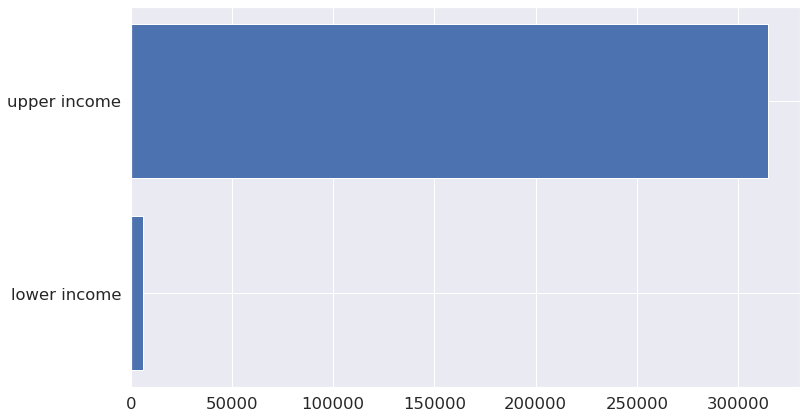

In [27]:
plt.barh(['lower income', 'upper income'], 
         [design_df_lower.Income.mean(), design_df_upper.Income.mean()])

Text(0.5, 1.0, 'Mean number of languages')

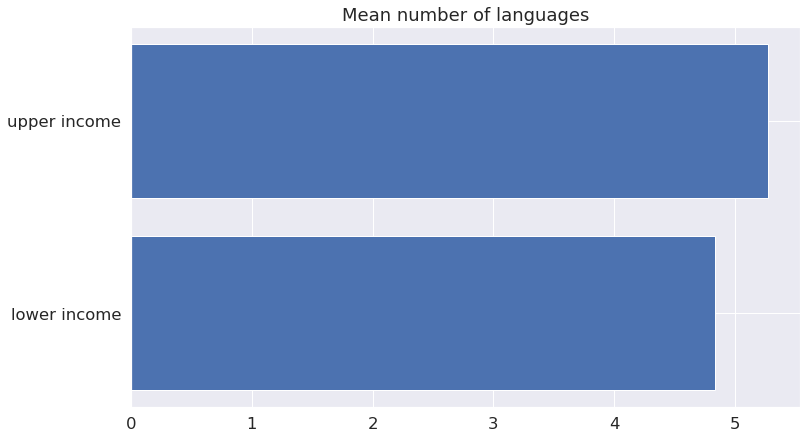

In [28]:
plt.barh(['lower income', 'upper income'], 
         [design_df_lower.Number_languages.mean(), design_df_upper.Number_languages.mean()])
plt.title('Mean number of languages')

**Observation:**

- Similar prevalence of languages in low and high income users
- Slightly higher mean number of languages in high income

In [29]:
from sklearn.decomposition import PCA

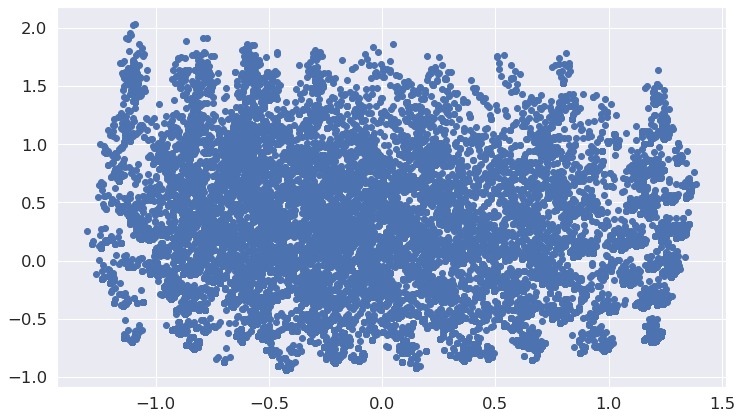

In [30]:
pca = PCA(n_components=3)
fitted = pca.fit_transform(design_df[languages])
plt.scatter(fitted[:, 0], fitted[:, 1])

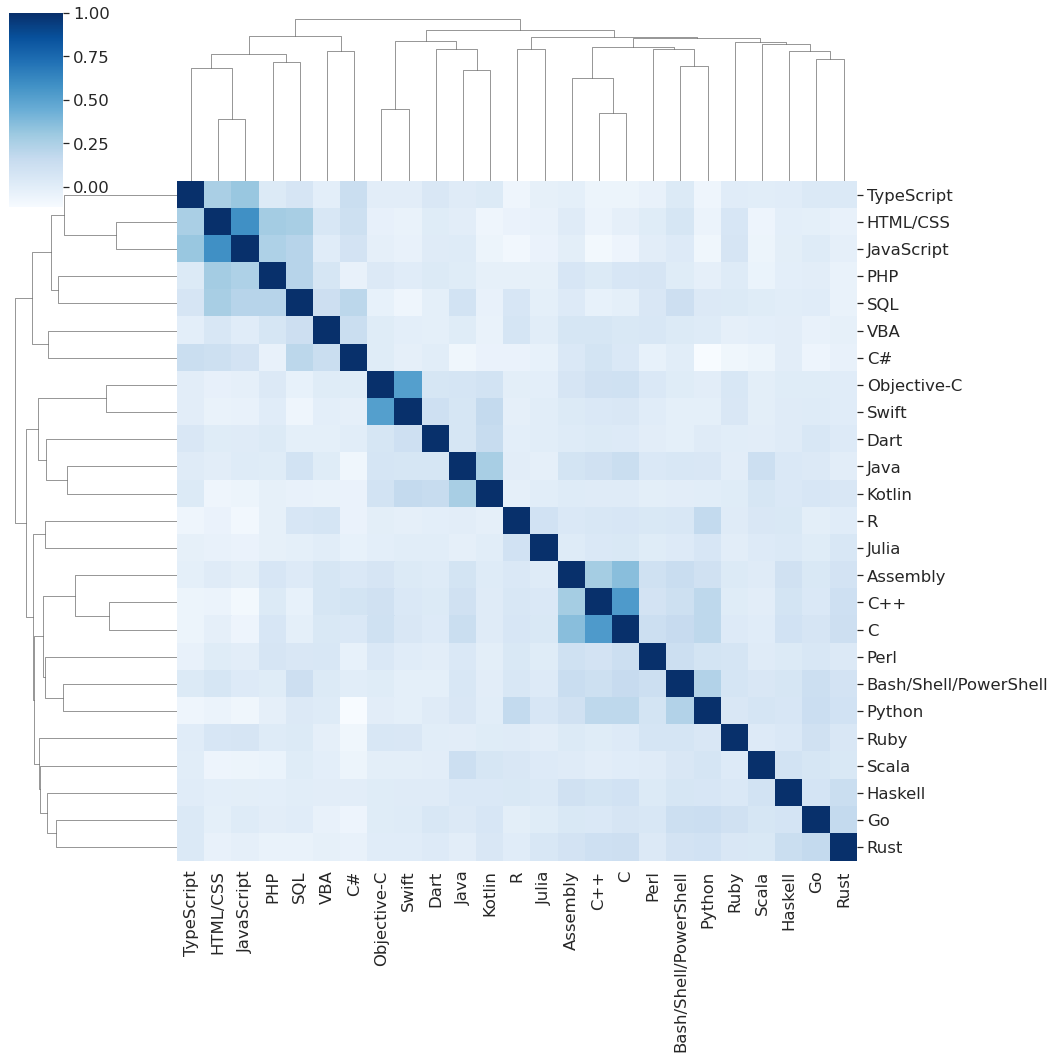

In [31]:
sns.clustermap(design_df[languages].corr(),
              figsize=(15,15),
              cmap='Blues')

# Modeling

- Target is heavy tailed $\rightarrow$ transform

Text(0.5, 1.0, 'Income Histogram [log2-transformed]')

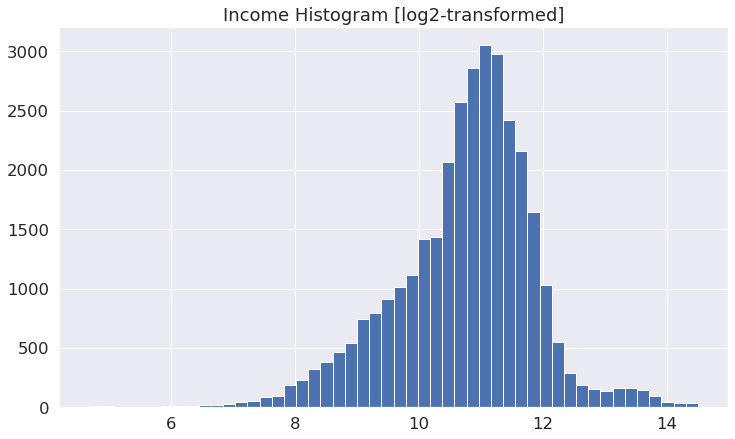

In [32]:
mask = design_df.Income > 1e2
design_df.loc[mask, 'Income'].apply(np.log).hist(bins=50)
plt.title('Income Histogram [log2-transformed]')

**Observation:**

- Skewed

Text(0.5, 1.0, 'Income Histogram [cube-root-transformed]')

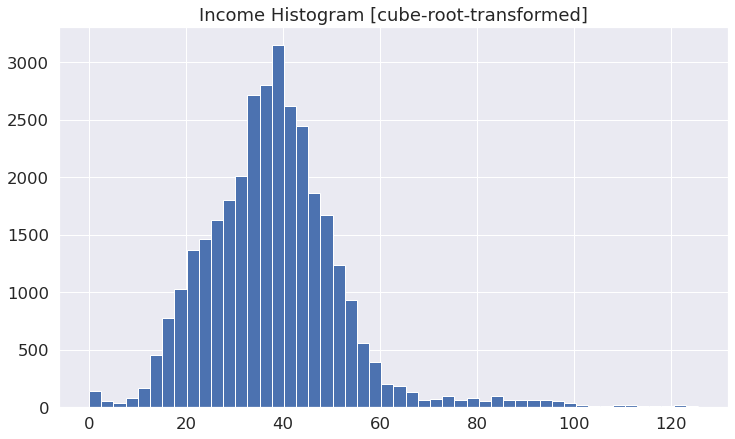

In [33]:
# Transform predictor?
design_df['Income'].apply(lambda x: x**(1/3)).hist(bins=50)
plt.title('Income Histogram [cube-root-transformed]')

**Observation:**

- Almost symmetric
- Cut ends

In [34]:
70**3

343000

In [35]:
mask = ((design_df.Income < 3.5e5) &
       (design_df.Income > 1e3))
X = design_df[mask].drop(columns='Income')
# X = design_df.loc[mask, indicative_languages + ['Number_languages']]
# X = design_df.loc[mask, 'Number_languages'].to_frame()
y = design_df.loc[mask, 'Income'].apply(lambda x: x**(1/3))

# mask = y < 70
# X = X[mask]
# y = y[mask]

# X = design_df.drop(columns='Income')
# X = design_df['Number_languages'].to_frame()
# y = design_df['Income'].apply(lambda x: x**(1/3))

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.3,
                                                    random_state=42)

In [36]:
X_train.head()

C++  Scala  Go  Java  Rust  TypeScript  HTML/CSS  \
46867    0      0   0     0     0           0         1   
9843     0      0   1     0     0           0         0   
51009    0      0   0     0     1           0         0   
53560    0      0   0     0     0           0         0   
31177    0      0   0     1     0           0         1   

       Bash/Shell/PowerShell  Perl  Objective-C  ...  SQL  VBA  Dart  Ruby  \
46867                      0     0            0  ...    1    1     0     0   
9843                       0     0            0  ...    0    0     0     0   
51009                      1     0            0  ...    0    0     0     0   
53560                      0     0            0  ...    1    0     0     0   
31177                      0     0            0  ...    0    0     0     0   

       C#  Assembly  C  JavaScript  Python  Number_languages  
46867   1         0  0           1       0                 5  
9843    1         0  0           1       0                 3  
51009   0         1  1           0       0                 4  
53560   1         0  0           1       0                 4  
31177   1         0  0           1       1                 5  

[5 rows x 26 columns]

## Spot Checking

>lasso-0.0: 0.110 +/- 0.006
>lasso-0.3: 0.100 +/- 0.006
>lasso-0.7: 0.071 +/- 0.004
>lasso-1.0: 0.055 +/- 0.003
>ridge-0.0: 0.110 +/- 0.006
>ridge-0.3: 0.110 +/- 0.006
>ridge-0.7: 0.110 +/- 0.006
>ridge-1.0: 0.110 +/- 0.006
>en-0.0-0.0: 0.110 +/- 0.006
>en-0.0-0.3: 0.110 +/- 0.006
>en-0.0-0.7: 0.110 +/- 0.006
>en-0.0-1.0: 0.110 +/- 0.006
>en-0.3-0.0: 0.105 +/- 0.005
>en-0.3-0.3: 0.105 +/- 0.005
>en-0.3-0.7: 0.102 +/- 0.006
>en-0.3-1.0: 0.100 +/- 0.006
>en-0.7-0.0: 0.095 +/- 0.004
>en-0.7-0.3: 0.090 +/- 0.004
>en-0.7-0.7: 0.079 +/- 0.005
>en-0.7-1.0: 0.071 +/- 0.004
>en-1.0-0.0: 0.087 +/- 0.003
>en-1.0-0.3: 0.078 +/- 0.003
>en-1.0-0.7: 0.062 +/- 0.003
>en-1.0-1.0: 0.055 +/- 0.003
>knn-1: -0.747 +/- 0.047
>knn-2: -0.330 +/- 0.020
>knn-3: -0.150 +/- 0.016
>knn-4: -0.096 +/- 0.018
>knn-5: -0.051 +/- 0.020
>knn-6: -0.020 +/- 0.013
>knn-7: 0.000 +/- 0.012
>knn-8: 0.018 +/- 0.010
>knn-9: 0.031 +/- 0.014
>knn-10: 0.041 +/- 0.013
>knn-11: 0.048 +/- 0.009
>cart: -0.191 +/- 0.005
>extra: -0.130 +

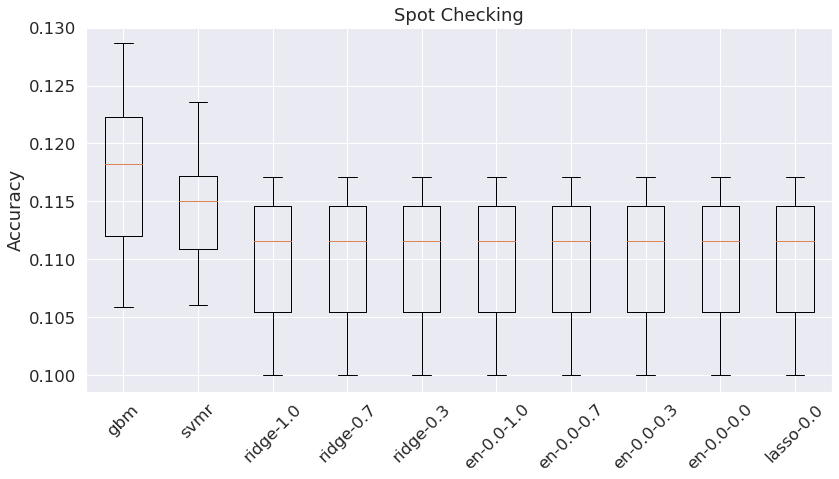

In [37]:
models = {}

# linear models
alpha = [0.0, 0.3, 0.7, 1.0]
for a in alpha:
    models['lasso-' + str(a)] = Lasso(alpha=a)
for a in alpha:
    models['ridge-' + str(a)] = Ridge(alpha=a)
for a1 in alpha:
    for a2 in alpha:
        models['en-' + str(a1) + '-' + str(a2)] = ElasticNet(alpha=a1, l1_ratio=a2)
        
# non-linear models
n_neighbors = range(1, 12)
for k in n_neighbors:
    models['knn-' + str(k)] = KNeighborsRegressor(n_neighbors=k)
models['cart'] = DecisionTreeRegressor()
models['extra'] = ExtraTreesRegressor()
models['svml'] = SVR(kernel='linear')
models['svmp'] = SVR(kernel='poly')
models['svmr'] = SVR()

# ensemble models
n_trees = 100
models['ada'] = AdaBoostRegressor(n_estimators=n_trees)
models['bag'] = BaggingRegressor(n_estimators=n_trees)
models['rf'] = RandomForestRegressor(n_estimators=n_trees)
models['et'] = ExtraTreesRegressor(n_estimators=n_trees)
models['gbm'] = GradientBoostingRegressor(n_estimators=n_trees)

# Evaluate models
cv = 5
# standardize_vars = ['tripduration', 'start station latitude', 'start station longitude', 'age']
# X_tmp = X_train_sub_balanced[used_vars].copy()
# X_tmp[standardize_vars] = StandardScaler().fit_transform(X_tmp[standardize_vars])
# results = SpotChecking.evaluate_models(X_tmp, y_train_sub_balanced, models, cv=cv, metric='accuracy', n_jobs=3)
results = SpotChecking.evaluate_models(X_train, y_train, models, cv=cv, metric='r2', n_jobs=3)

# Summarize results
fig = plt.figure(figsize=(12, 7))
SpotChecking.summarize_results(results)
plt.title('Spot Checking')
plt.ylabel('Accuracy')
plt.tight_layout()
# plt.savefig(data_out + 'spotchecking.png', dpi=300)
plt.show()

# Model tuning

In [39]:
mask = ((design_df.Income < 3.5e5) &
       (design_df.Income > 1e3))
X = design_df[mask].drop(columns='Income')
# X = design_df.loc[mask, indicative_languages + ['Number_languages']]
# X = design_df.loc[mask, 'Number_languages'].to_frame()
y = design_df.loc[mask, 'Income'].apply(lambda x: x**(1/3))

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.3,
                                                    random_state=42)

In [44]:
seed = 42

n_splits = 5
n_repeats = 1

cv = RepeatedKFold(n_splits=n_splits, 
                   n_repeats=n_repeats,
                   random_state=seed)

models = {}
param_dists = {}

models['gbm'] = Pipeline([
#     ('select_kbest', SelectKBest(f_regression)),
    ('model', GradientBoostingRegressor(n_estimators=100))
])
models['svr'] = Pipeline([
#     ('select_kbest', SelectKBest(f_regression)),
    ('model', SVR())
])


param_dists['gbm'] = {
    # 'model__min_weight_fraction_leaf':
    'model__learning_rate': uniform(0.001, 0.2),
    'model__subsample': uniform(.5, .5),
    'model__max_depth': randint(1, 100), 
#     'model__max_features': [1 / 3, 2 / 3, 'sqrt', 'log2', None],
    'model__max_features': uniform(0.0, 1.0),
    'model__min_samples_split': randint(2, 20),
    'model__min_samples_leaf': randint(1, 20),
#     'model__n_estimators': randint(10, 500),
}

param_dists['svr'] = {
#     'select_kbest__k': randint(1, X.shape[1]),
    'model__C': loguniform(-10, 1), 
}

rand_search_models = {}
for m in models:
    rand_search_models[m] = RandomizedSearchCV(models[m],
                                              cv=cv,
                                              n_iter=20,
                                              param_distributions=param_dists[m],
                                              n_jobs=-1)

In [45]:
results = pd.Series(index=['gbm', 'svr'], dtype=float)
for m in models:
    rand_search_models[m].fit(X_train, y_train)
    results[m] = rand_search_models[m].score(X_test, y_test)

Text(0, 0.5, '$R^2$')

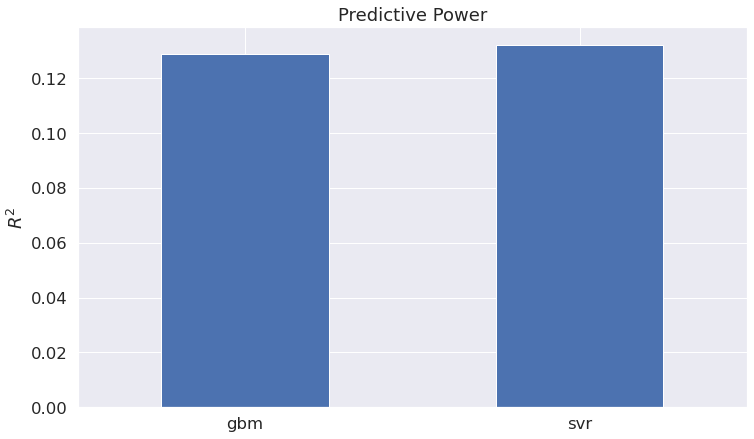

In [51]:
results.plot(kind='bar')
plt.xticks(rotation=0)
plt.title('Predictive Power')
plt.ylabel(r'$R^2$')

Text(0, 0.5, '$R^2$')

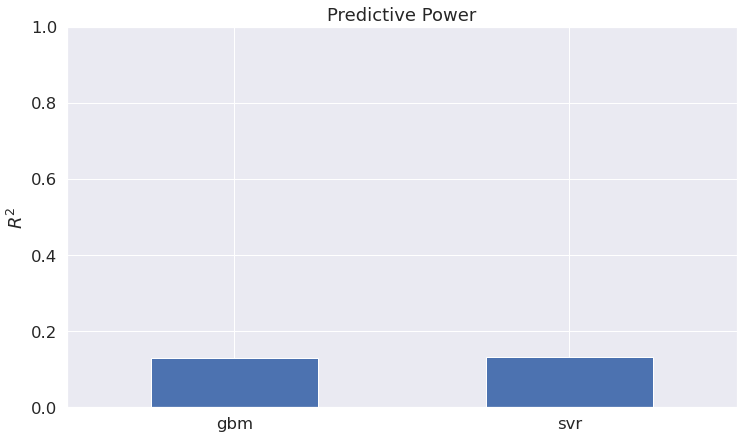

In [73]:
results.plot(kind='bar')
plt.xticks(rotation=0)
plt.title('Predictive Power')
plt.ylim((0, 1))
plt.ylabel(r'$R^2$')

## Classifying the tails

In [53]:
y = design_df.loc[mask, 'Income'].apply(lambda x: x**(1/3))
y = y.sort_values()
y = y.iloc[np.hstack([np.arange(4000), np.arange(-4000, 0, 1)])]
y.iloc[:4000] = 0
y.iloc[4000:] = 1

X = design_df.loc[y.index].drop(columns='Income')

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.3,
                                                    random_state=42)

In [54]:
seed = 42

n_splits = 5
n_repeats = 1

cv = RepeatedStratifiedKFold(n_splits=n_splits, 
                             n_repeats=n_repeats,
                             random_state=seed)

model = Pipeline([
#     ('select_kbest', SelectKBest(f_regression)),
    ('model', GradientBoostingClassifier(n_estimators=100))
])

param_dist = {
    # 'model__min_weight_fraction_leaf':
    'model__learning_rate': uniform(0.001, 0.2),
    'model__subsample': uniform(.5, .5),
    'model__max_depth': randint(1, 100), 
#     'model__max_features': [1 / 3, 2 / 3, 'sqrt', 'log2', None],
    'model__max_features': uniform(0.0, 1.0),
    'model__min_samples_split': randint(2, 20),
    'model__min_samples_leaf': randint(1, 20),
#     'model__n_estimators': randint(10, 500),
}


rand_search_model = RandomizedSearchCV(model,cv=cv,
                                       n_iter=20,
                                       param_distributions=param_dist,
                                       n_jobs=-1)

rand_search_model.fit(X_train, y_train)

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=5, random_state=42),
                   estimator=Pipeline(steps=[('model',
                                              GradientBoostingClassifier())]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'model__learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd032f48e80>,
                                        'model__max_depth': <scipy.stats._distn_infrastructure.rv_frozen ob...
                                        'model__max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd032bb6320>,
                                        'model__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd03284e9e8>,
                                        'model__min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd032af6ef0>,
                                        'model__subsample': <scipy.stats._d

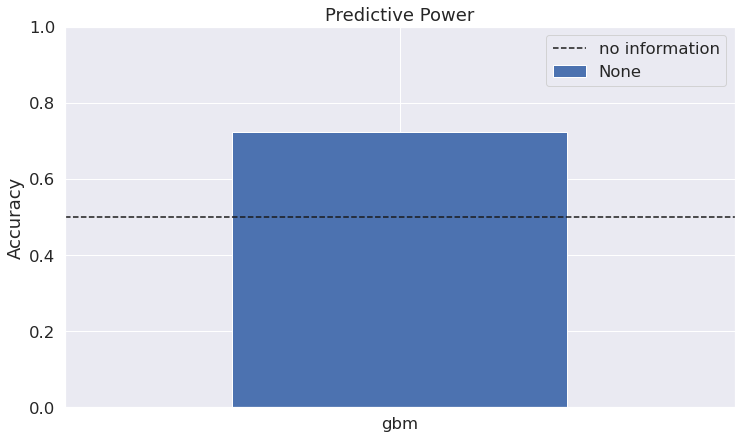

In [70]:
score = rand_search_model.score(X_test, y_test)
score = pd.Series(score, index=['gbm'])
score.plot(kind='bar')
ax = plt.gca()
xlim = ax.get_xlim()
plt.ylim(0, 1)
plt.hlines(.5, xmin=xlim[0], xmax=xlim[1], label='no information', color='k', linestyle='--')
plt.xticks(rotation=0)
plt.title('Predictive Power')
plt.ylabel('Accuracy')
plt.legend()

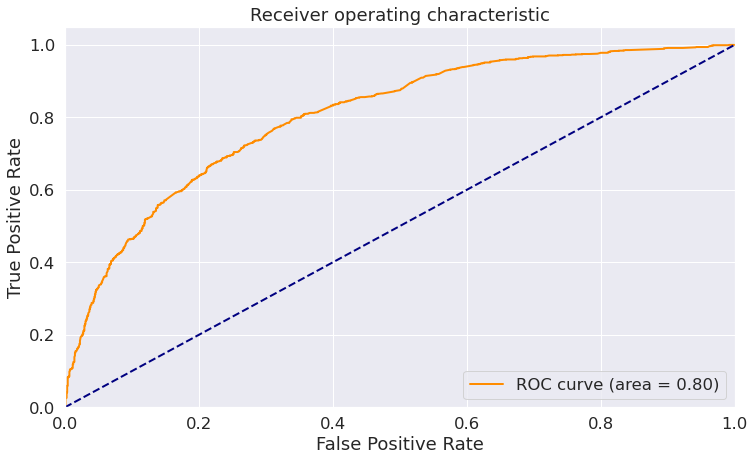

In [56]:
## ROC Curve

y_proba = rand_search_model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_proba[:, 1], pos_label=1)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()